# Unified Activity-Lifecycle Model Training

Train a single model that predicts both next activity AND lifecycle transition.
This approach avoids simulation loops by tracking state through lifecycle phases.

**Overnight Training Configuration:**
- Full BPIC17 dataset (~1.2M events)
- 20 epochs with early stopping
- Checkpoints saved every epoch
- Evaluation on holdout set


In [1]:
import sys
import os
import warnings
import importlib

# Add parent to path
sys.path.insert(0, os.path.dirname(os.getcwd()))

import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter

# Force reload modules to pick up changes
import unified
import unified.model
import unified.data_generator
importlib.reload(unified.model)
importlib.reload(unified.data_generator)
importlib.reload(unified)

from unified import UnifiedDataGenerator, UnifiedPredictor, UnifiedModelPersistence

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")

print(f"Training started: {datetime.now()}")


Training started: 2026-01-05 03:33:11.675027


d:\Repos\process-simulation-engine\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## 1. Configuration


In [ ]:
# Paths
XES_PATH = os.path.join(os.getcwd(), "..", "..", "..", "Dataset", "BPI Challenge 2017.xes")
MODEL_DIR = os.path.join(os.getcwd(), "..", "..", "..", "models", "unified_next_activity")
CHECKPOINT_DIR = os.path.join(MODEL_DIR, "checkpoints")

# Training parameters - IMPROVED FOR BETTER ACCURACY
MAX_HISTORY = 20  # Longer history for better context
MIN_SAMPLES = 5   # Lower threshold to keep more data
EPOCHS = 1       # More epochs with early stopping
BATCH_SIZE = 128  # Smaller batch for better gradients
VALIDATION_SPLIT = 0.1
TEST_SIZE = 0.1
RANDOM_STATE = 42

# Model architecture - LARGER MODEL
LSTM_UNITS = 256
HIDDEN_UNITS = 256

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print(f"Model will be saved to: {MODEL_DIR}")


Model will be saved to: d:\Repos\process-simulation-engine\Next-Activity-Prediction\advanced\notebooks\..\..\..\models\unified_next_activity


## 2. Load Event Log


In [3]:
print(f"Loading event log from: {XES_PATH}")
event_log = xes_importer.apply(XES_PATH)
df_log = log_converter.apply(event_log, variant=log_converter.Variants.TO_DATA_FRAME)

print(f"Loaded {len(df_log):,} events from {df_log['case:concept:name'].nunique():,} cases")
print(f"\nColumns: {list(df_log.columns)}")


Loading event log from: d:\Repos\process-simulation-engine\Next-Activity-Prediction\advanced\notebooks\..\..\..\Dataset\BPI Challenge 2017.xes


parsing log, completed traces :: 100%|██████████| 31509/31509 [00:34<00:00, 923.45it/s] 


Loaded 1,202,267 events from 31,509 cases

Columns: ['Action', 'org:resource', 'concept:name', 'EventOrigin', 'EventID', 'lifecycle:transition', 'time:timestamp', 'case:LoanGoal', 'case:ApplicationType', 'case:concept:name', 'case:RequestedAmount', 'FirstWithdrawalAmount', 'NumberOfTerms', 'Accepted', 'MonthlyCost', 'Selected', 'CreditScore', 'OfferedAmount', 'OfferID']


In [4]:
# Check for lifecycle column
if 'lifecycle:transition' in df_log.columns:
    print("Lifecycle transitions found:")
    print(df_log['lifecycle:transition'].value_counts())
else:
    print("No lifecycle column - will use 'complete' as default")


Lifecycle transitions found:
lifecycle:transition
complete     475306
suspend      215402
schedule     149104
start        128227
resume       127160
ate_abort     85224
withdraw      21844
Name: count, dtype: int64


In [5]:
# Activity distribution
print(f"\nUnique activities: {df_log['concept:name'].nunique()}")
print("\nTop 15 activities:")
print(df_log['concept:name'].value_counts().head(15))



Unique activities: 26

Top 15 activities:
concept:name
W_Validate application      209496
W_Call after offers         191092
W_Call incomplete files     168529
W_Complete application      148900
W_Handle leads               47264
O_Create Offer               42995
O_Created                    42995
O_Sent (mail and online)     39707
A_Validating                 38816
A_Accepted                   31509
A_Create Application         31509
A_Concept                    31509
A_Complete                   31362
O_Returned                   23305
A_Incomplete                 23055
Name: count, dtype: int64


## 3. Generate Training Data


In [6]:
print("Generating training data with lifecycle...")
generator = UnifiedDataGenerator(
    df_log,
    max_history=MAX_HISTORY,
    min_samples=MIN_SAMPLES,
)

df_train = generator.generate()
print(f"Generated {len(df_train):,} training samples")


Generating training data with lifecycle...
Generated 1,170,749 training samples


In [ ]:
# Target distributions
print(f"\nTarget activity distribution ({df_train['target_activity'].nunique()} classes):")
print(df_train['target_activity'].value_counts().head(10))

print(f"\nTarget lifecycle distribution ({df_train['target_lifecycle'].nunique()} classes):")
print(df_train['target_lifecycle'].value_counts())



Target activity distribution (25 classes):
target_activity
W_Validate application      209496
W_Call after offers         191092
W_Call incomplete files     168529
W_Complete application      148900
W_Handle leads               47264
O_Created                    42995
O_Create Offer               42995
O_Sent (mail and online)     39707
A_Validating                 38816
A_Accepted                   31509
Name: count, dtype: int64

Target lifecycle distribution (7 classes):
target_lifecycle
complete     443797
suspend      215402
schedule     149102
start        128223
resume       127160
ate_abort     85224
withdraw      21841
Name: count, dtype: int64


## 4. Train/Test Split


In [8]:
# Stratified split by target activity
df_train_set, df_test_set = train_test_split(
    df_train,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_train['target_activity']
)

print(f"Training set: {len(df_train_set):,} samples")
print(f"Test set: {len(df_test_set):,} samples")


Training set: 1,053,674 samples
Test set: 117,075 samples


## 5. Train Model


In [9]:
print(f"\n{'='*60}")
print("TRAINING UNIFIED MODEL (IMPROVED)")
print(f"{'='*60}")
print(f"Started: {datetime.now()}")
print(f"Epochs: {EPOCHS} (with early stopping)")
print(f"Batch size: {BATCH_SIZE}")
print(f"LSTM units: {LSTM_UNITS}")
print(f"Hidden units: {HIDDEN_UNITS}")
print(f"Using: Attention, LR reduction, BatchNorm")
print(f"{'='*60}\n")

# Create predictor
predictor = UnifiedPredictor(
    max_seq_len=MAX_HISTORY,
    lstm_units=LSTM_UNITS,
    hidden_units=HIDDEN_UNITS,
)

# Train model
checkpoint_path = os.path.join(CHECKPOINT_DIR, "best_model.keras")
history = predictor.fit(
    df_train_set,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    checkpoint_path=checkpoint_path,
)

print(f"\nTraining completed: {datetime.now()}")



TRAINING UNIFIED MODEL (IMPROVED)
Started: 2026-01-05 03:35:01.950884
Epochs: 30 (with early stopping)
Batch size: 128
LSTM units: 256
Hidden units: 256
Using: Attention, LR reduction, BatchNorm


Activity classes: 25, samples: 1053674
  Most common: 188546 samples, Least common: 14 samples
Epoch 1/30
7409/7409 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - activity_accuracy: 0.8482 - activity_loss: 0.4823 - lifecycle_accuracy: 0.7595 - lifecycle_loss: 0.6205 - loss: 0.6685
Epoch 1: val_activity_accuracy improved from None to 0.92748, saving model to d:\Repos\process-simulation-engine\Next-Activity-Prediction\advanced\notebooks\..\..\..\models\unified_next_activity\checkpoints\best_model.keras

Epoch 1: finished saving model to d:\Repos\process-simulation-engine\Next-Activity-Prediction\advanced\notebooks\..\..\..\models\unified_next_activity\checkpoints\best_model.keras
7409/7409 ━━━━━━━━━━━━━━━━━━━━ 1587s 213ms/step - activity_accuracy: 0.9050 - activity_loss: 0.2976 - lifecycle_accuracy: 0.8

KeyboardInterrupt: 

In [11]:
# LOAD FROM CHECKPOINT - Run this cell to load saved model and check accuracy
from tensorflow.keras.models import load_model
import tensorflow as tf
import keras

checkpoint_path = os.path.join(CHECKPOINT_DIR, "best_model.keras")

# Custom layer for loading - handle different Keras versions
try:
    _register = keras.saving.register_keras_serializable
except AttributeError:
    try:
        _register = keras.utils.register_keras_serializable
    except AttributeError:
        _register = lambda package: lambda fn: fn

@_register(package="UnifiedLayers")
def expand_and_cast(x):
    return tf.cast(tf.expand_dims(x, axis=-1), tf.float32)

print(f"Loading model from checkpoint: {checkpoint_path}")
loaded_model = load_model(checkpoint_path, custom_objects={"expand_and_cast": expand_and_cast}, safe_mode=False)
print("Model loaded successfully!")
print(f"Model summary:")
loaded_model.summary()

# Assign to predictor for later use
predictor.model = loaded_model


Loading model from checkpoint: d:\Repos\process-simulation-engine\Next-Activity-Prediction\advanced\notebooks\..\..\..\models\unified_next_activity\checkpoints\best_model.keras
Model loaded successfully!
Model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ activities          │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lifecycles          │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ durations           │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resources           │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 20, 64)    │      1,792 │ activities[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 20, 16)    │        144 │ lifecycles[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 20, 1)     │          0 │ durations[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 20, 32)    │      4,832 │ resources[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 20)        │          0 │ activities[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 20)        │          0 │ lifecycles[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 20)        │          0 │ resources[0][0]   │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 20, 1)     │          4 │ lambda[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand_dims         │ (None, 20, 1)     │          0 │ not_equal[0][0]   │
│ (ExpandDims)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zeros_like          │ (None, 20, 64)    │          0 │ embedding[0][0]   │
│ (ZerosLike)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand_dims_1       │ (None, 20, 1)     │          0 │ not_equal_1[0][0] │
│ (ExpandDims)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zeros_like_1        │ (None, 20, 16)    │          0 │ embedding_1[0][0] │
│ (ZerosLike)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand_dims_2       │ (None, 20, 1)     │          0 │ not_equal_2[0][0] │
│ (ExpandDims)        │                   │            │                 

 Total params: 5,414,714 (20.66 MB)

 Trainable params: 1,804,690 (6.88 MB)

 Non-trainable params: 642 (2.51 KB)

 Optimizer params: 3,609,382 (13.77 MB)

## 6. Training History


NameError: name 'history' is not defined

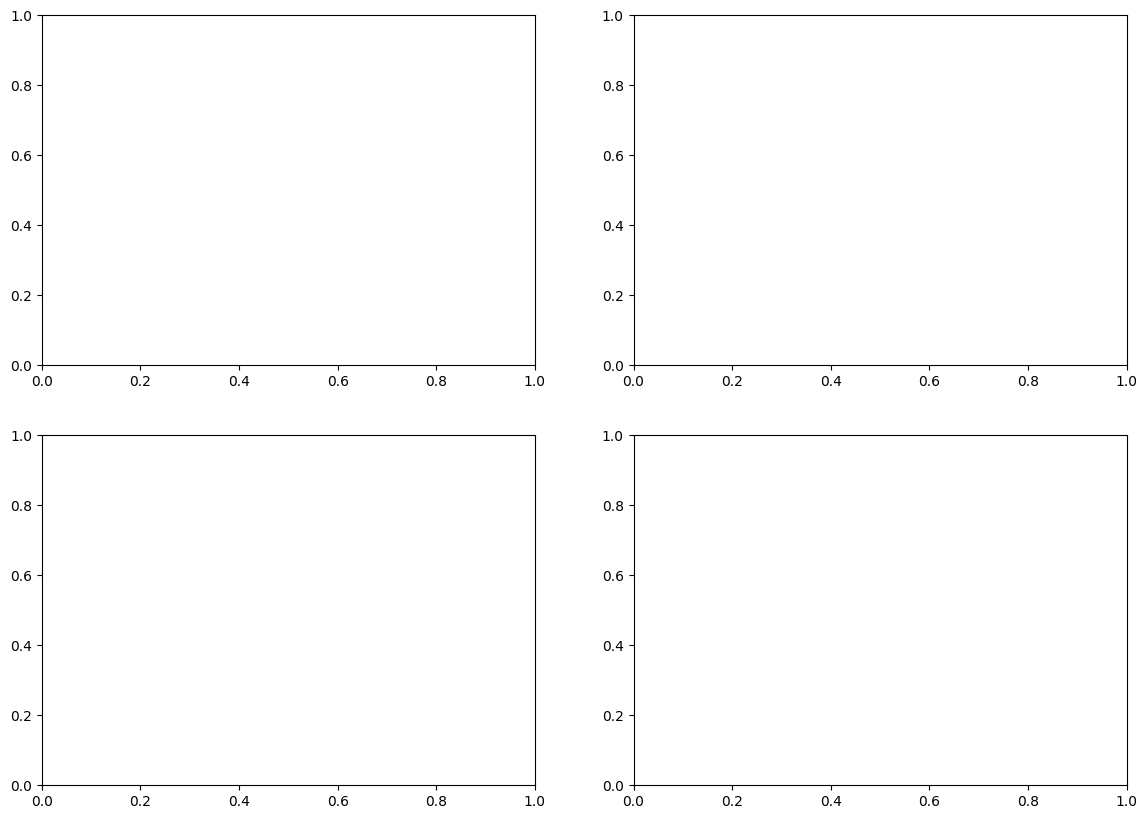

In [12]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Activity accuracy
axes[0, 0].plot(history.history['activity_accuracy'], label='Train')
axes[0, 0].plot(history.history['val_activity_accuracy'], label='Validation')
axes[0, 0].set_title('Activity Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].legend()

# Lifecycle accuracy
axes[0, 1].plot(history.history['lifecycle_accuracy'], label='Train')
axes[0, 1].plot(history.history['val_lifecycle_accuracy'], label='Validation')
axes[0, 1].set_title('Lifecycle Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].legend()

# Total loss
axes[1, 0].plot(history.history['loss'], label='Train')
axes[1, 0].plot(history.history['val_loss'], label='Validation')
axes[1, 0].set_title('Total Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].legend()

# Activity loss
axes[1, 1].plot(history.history['activity_loss'], label='Train Activity')
axes[1, 1].plot(history.history['lifecycle_loss'], label='Train Lifecycle')
axes[1, 1].set_title('Component Losses')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'training_history.png'), dpi=150)
plt.show()


## 7. Evaluate on Test Set


In [13]:
# Prepare test data using a fresh encoder fitted on test data for proper evaluation
from unified.model import UnifiedEncoder

test_encoder = UnifiedEncoder(predictor.context_keys)
X_test, y_act_test, y_lc_test = test_encoder.fit_transform(df_test_set)

# Evaluate
test_results = predictor.model.evaluate(
    X_test,
    {'activity': y_act_test, 'lifecycle': y_lc_test},
    verbose=1
)

print(f"\nTest Results:")
for name, value in zip(predictor.model.metrics_names, test_results):
    print(f"  {name}: {value:.4f}")


3659/3659 ━━━━━━━━━━━━━━━━━━━━ 99s 26ms/step - activity_accuracy: 0.9316 - activity_loss: 0.1899 - lifecycle_accuracy: 0.9011 - lifecycle_loss: 0.2291 - loss: 0.2587

Test Results:
  loss: 0.2587
  compile_metrics: 0.1899
  activity_loss: 0.2291
  lifecycle_loss: 0.9316


In [14]:
# Predict on test set
predictions = predictor.model.predict(X_test, verbose=0)
pred_activities = np.argmax(predictions[0], axis=1)
pred_lifecycles = np.argmax(predictions[1], axis=1)

# Joint accuracy (both correct)
joint_correct = (pred_activities == y_act_test) & (pred_lifecycles == y_lc_test)
joint_accuracy = joint_correct.mean()
print(f"\nJoint Accuracy (both activity AND lifecycle correct): {joint_accuracy:.4f}")



Joint Accuracy (both activity AND lifecycle correct): 0.8873


## 8. Save Model


In [15]:
print(f"Saving model to: {MODEL_DIR}")
UnifiedModelPersistence.save(predictor, MODEL_DIR)
print("Model saved successfully!")


Saving model to: d:\Repos\process-simulation-engine\Next-Activity-Prediction\advanced\notebooks\..\..\..\models\unified_next_activity
Model saved successfully!


In [16]:
# Save training summary
import json

summary = {
    'training_samples': len(df_train_set),
    'test_samples': len(df_test_set),
    'num_activities': predictor.encoder.num_target_activities,
    'num_lifecycles': predictor.encoder.num_target_lifecycles,
    'epochs_trained': len(history.history['loss']),
    'final_val_activity_accuracy': history.history['val_activity_accuracy'][-1],
    'final_val_lifecycle_accuracy': history.history['val_lifecycle_accuracy'][-1],
    'test_joint_accuracy': float(joint_accuracy),
    'training_completed': str(datetime.now()),
}

with open(os.path.join(MODEL_DIR, 'training_summary.json'), 'w') as f:
    json.dump(summary, f, indent=2)

print("\nTraining Summary:")
for k, v in summary.items():
    print(f"  {k}: {v}")


NameError: name 'history' is not defined

## 9. Quick Inference Test


In [17]:
# Test inference
sample_activities = ["A_Create Application", "A_Submitted", "W_Handle leads"]
sample_lifecycles = ["complete", "complete", "complete"]
sample_resources = ["User_1", "User_1", "User_2"]
sample_durations = [0.0, 120.0, 300.0]
sample_context = {
    "case:LoanGoal": "Home improvement",
    "case:ApplicationType": "New credit",
    "case:RequestedAmount": 15000.0,
}

act_preds, lc_preds = predictor.predict(
    sample_activities, sample_lifecycles, sample_resources,
    sample_durations, sample_context, top_k=5
)

print("\nSample Prediction:")
print(f"History: {sample_activities}")
print(f"\nTop 5 predicted activities:")
for act, prob in act_preds:
    print(f"  {act}: {prob:.4f}")

print(f"\nTop 5 predicted lifecycles:")
for lc, prob in lc_preds:
    print(f"  {lc}: {prob:.4f}")



Sample Prediction:
History: ['A_Create Application', 'A_Submitted', 'W_Handle leads']

Top 5 predicted activities:
  W_Call incomplete files: 0.7618
  A_Cancelled: 0.2291
  W_Assess potential fraud: 0.0054
  O_Create Offer: 0.0017
  O_Cancelled: 0.0010

Top 5 predicted lifecycles:
  schedule: 0.4405
  suspend: 0.3437
  complete: 0.2131
  start: 0.0024
  ate_abort: 0.0002


## 10. Test Integration with Simulation Engine


In [18]:
# Test loading the model for simulation
import sys
sys.path.insert(0, os.path.join(os.getcwd(), "..", "..", ".."))

# Reload persistence module
import importlib
import unified.persistence
importlib.reload(unified.persistence)
from unified.persistence import UnifiedModelPersistence

print(f"Testing model load from: {MODEL_DIR}")
bundle = UnifiedModelPersistence.load(MODEL_DIR)
print(f"Model loaded successfully!")
print(f"Encoder has {bundle['encoder'].num_target_activities} target activities")
print(f"Encoder has {bundle['encoder'].num_target_lifecycles} target lifecycles")

# Test prediction
test_activities = ["A_Create Application", "A_Submitted"]
test_lifecycles = ["complete", "complete"]
test_resources = ["User_1", "User_1"]
test_durations = [0.0, 60.0]
test_context = {
    "case:LoanGoal": "Home improvement",
    "case:ApplicationType": "New credit",
    "case:RequestedAmount": 15000.0,
}

act_preds, lc_preds = bundle["model"].predict(
    test_activities, test_lifecycles, test_resources, test_durations, test_context
)

print(f"\nTest prediction:")
print(f"  Input: {test_activities}")
print(f"  Top predicted activities:")
for act, prob in act_preds[:3]:
    print(f"    {act}: {prob:.4f}")
print(f"  Top predicted lifecycles:")
for lc, prob in lc_preds[:3]:
    print(f"    {lc}: {prob:.4f}")


Testing model load from: d:\Repos\process-simulation-engine\Next-Activity-Prediction\advanced\notebooks\..\..\..\models\unified_next_activity
Model loaded successfully!
Encoder has 25 target activities
Encoder has 7 target lifecycles

Test prediction:
  Input: ['A_Create Application', 'A_Submitted']
  Top predicted activities:
    W_Handle leads: 1.0000
    W_Call incomplete files: 0.0000
    W_Call after offers: 0.0000
  Top predicted lifecycles:
    schedule: 1.0000
    complete: 0.0000
    start: 0.0000


In [19]:
# Test with simulation engine's UnifiedNextActivityPredictor
from dataclasses import dataclass
from typing import List, Optional

@dataclass
class MockCaseState:
    """Mock CaseState for testing."""
    case_id: str = "test_case_1"
    case_type: str = "Home improvement"
    application_type: str = "New credit"
    requested_amount: float = 15000.0
    activity_history: List[str] = None
    current_resource: Optional[str] = "User_1"
    
    def __post_init__(self):
        if self.activity_history is None:
            self.activity_history = []

# Test the predictor
from unified.predictor import UnifiedNextActivityPredictor

print("Testing UnifiedNextActivityPredictor for simulation...")
sim_predictor = UnifiedNextActivityPredictor(model_path=MODEL_DIR, seed=42)

# Simulate a case
case = MockCaseState()
print(f"\nSimulating case: {case.case_id}")

for step in range(10):
    next_act, is_end = sim_predictor.predict(case)
    case.activity_history.append(next_act)
    print(f"  Step {step+1}: {next_act} (end={is_end})")
    if is_end:
        break

print(f"\nFull trace: {' -> '.join(case.activity_history)}")
print("\n✓ Integration test passed!")


Testing UnifiedNextActivityPredictor for simulation...

Simulating case: test_case_1
  Step 1: A_Create Application (end=False)
  Step 2: A_Submitted (end=False)
  Step 3: W_Handle leads (end=False)
  Step 4: W_Handle leads (end=False)
  Step 5: W_Complete application (end=False)
  Step 6: A_Concept (end=False)
  Step 7: W_Complete application (end=False)
  Step 8: W_Complete application (end=False)
  Step 9: W_Complete application (end=False)
  Step 10: A_Accepted (end=False)

Full trace: A_Create Application -> A_Submitted -> W_Handle leads -> W_Handle leads -> W_Complete application -> A_Concept -> W_Complete application -> W_Complete application -> W_Complete application -> A_Accepted

✓ Integration test passed!


In [20]:
print(f"\n{'='*60}")
print("TRAINING COMPLETE")
print(f"{'='*60}")
print(f"Model saved to: {MODEL_DIR}")
print(f"Completed: {datetime.now()}")



TRAINING COMPLETE
Model saved to: d:\Repos\process-simulation-engine\Next-Activity-Prediction\advanced\notebooks\..\..\..\models\unified_next_activity
Completed: 2026-01-05 13:51:52.968556
